# 1. Подготовка данных

In [ ]:
# Импорт необходимых библиотек
import os
import numpy as np
import pandas as pd

from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

state = 12345

In [ ]:
# Созадим списки датасетов
datasets = ['gold_recovery_train.csv', 'gold_recovery_test.csv', 'gold_recovery_full.csv']
directories = '/datasets/'

In [ ]:
dfs = []
for df in datasets:
    dfs.append(pd.read_csv(directories+df, index_col='date'))

In [ ]:
# объявим датасеты
train = dfs[0]
test = dfs[1]
full = dfs[2]

In [ ]:
train.shape, test.shape, full.shape

((16860, 86), (5856, 52), (22716, 86))

In [ ]:
# Признаки, которых нет в тесте
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тесте нет признаков output, так как это целевые признаки.

Так же в тесте нет признаков calculation для этапа rougher, скорее всего эти данные рассчитываются позднее и не доступны во время процесса.

Проверим расчет recovery в train:

- Вычислим recovery из сырых значений, проверим сколько из них совпало с предоставленными
- Вычислим MAE для рассчитанных значений и исходых

In [ ]:
def recovery(C, F, T):
    
    numerator = (C*(F-T))
    denominator =(F*(C-T))
    
    rec = numerator / denominator * 100
    
    # так как мы не застрахованы от очень больших и очень маленьких значений, то заполним их
    rec[rec<0] = np.nan
    rec[rec>100] = np.nan
    return rec

In [ ]:
t,f,c = train['rougher.output.tail_au'], train['rougher.input.feed_au'], train['rougher.output.concentrate_au']
rec = recovery(c, f, t)
# посчитаем кол-во близких значений методом inclose
right_recovery_sum = np.isclose(train['rougher.output.recovery'], rec).sum()
right_recovery_sum, train.shape[0]-right_recovery_sum

(14287, 2573)

Найдено 14287 совпадений и 2573 различий, скорее всего, там пропуски, проверим это

In [ ]:
train['rougher.output.recovery'].isna().sum(), rec.isna().sum()

(2573, 2573)

Действительно, в этом столбце именно такое количество пропусков. Заполним их нулями для расчета MAE

Вычислим MAE для рассчитанных значений и исходых

In [ ]:
mean_absolute_error(train['rougher.output.recovery'].fillna(0), rec.fillna(0))

8.00350954615662e-15

MAE имеет очень низкое значение, поэтому можно считать, что recovery считает правильно   
Проверим пропуски в train и test

In [ ]:
def isna_info(df):
    isna_percent = (df.isna().sum()/len(df)).sort_values(ascending=False)
    isna_count = df.isna().sum()
    print(pd.concat([isna_percent, isna_count], axis=1, keys=['percent', 'count']).sort_values('percent', ascending=False).head(10))
    print('Количество признаков с пропусками:',len(isna_count))

In [ ]:
isna_info(train)

                                     percent  count
rougher.output.recovery             0.152610   2573
rougher.output.tail_ag              0.133452   2250
rougher.output.tail_au              0.133393   2249
rougher.output.tail_sol             0.133393   2249
secondary_cleaner.output.tail_sol   0.117794   1986
rougher.input.floatbank11_xanthate  0.112930   1904
final.output.recovery               0.090214   1521
primary_cleaner.input.sulfate       0.077521   1307
primary_cleaner.input.depressant    0.074852   1262
rougher.calculation.au_pb_ratio     0.073665   1242
Количество признаков с пропусками: 86


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [ ]:
isna_info(test)

                                           percent  count
rougher.input.floatbank11_xanthate        0.060280    353
primary_cleaner.input.sulfate             0.051571    302
primary_cleaner.input.depressant          0.048497    284
rougher.input.floatbank10_sulfate         0.043887    257
primary_cleaner.input.xanthate            0.028347    166
rougher.input.floatbank10_xanthate        0.021004    123
rougher.input.feed_sol                    0.011441     67
rougher.input.floatbank11_sulfate         0.009392     55
rougher.input.feed_rate                   0.006831     40
secondary_cleaner.state.floatbank3_a_air  0.005806     34
Количество признаков с пропусками: 52


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


Пропуски в test незначительны

Пропуски в train более значитиельны, большая часть из них в целевых признаках output, так же в rougher.output.recovery пропусков 2573 что совпадает с количеством несовпавших расчетных значений. В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к. их невозможно получить/измерить во время выполнения технологического процесса.

Пока не будем обрабатывть пропуски, при машинном обучении на кросс-валидации проверим какой способ заполнения или удаления пропусков покажет себя лучше

## Подготовка данных к машинному обучению

- Удалим из train признаки которых нет в тесте
- Разделим данные на целевой признак и все остальные
- Так же разделим датасет на 2 части rougher и cleaner, так как процессы флотации и очистки независимы, то и предсказывать их тоже логично независимо.
- Возможно предсказывать recovery вообще неверный путь, так как он зависит от одного из обучающих параметров, может лучше для каждого процесса предсказыать output.concentrate и output.tail и затем на их основе уже считать recovery.

Проверим это на этапе машинного обучения, пока что просто запишем эти данные в отдельные переменные

In [ ]:
X_train = train[test.columns]

rougher_cols = X_train.columns.str.contains('rougher')
X_train_rougher = X_train.loc[:, rougher_cols]
X_test_rougher = test.loc[:, rougher_cols]
y_train_rougher = train[['rougher.output.tail_au', 'rougher.output.concentrate_au']]

final_cols = X_train.columns.str.contains('cleaner')
X_train_cleaner = X_train.loc[:, final_cols]
X_test_cleaner = test.loc[:, final_cols]
y_train_cleaner = train[['final.output.tail_au', 'final.output.concentrate_au']]

# 2. Анализ данных

Построим распределения концентраций металов на выходе каждого процесса и в хвостах

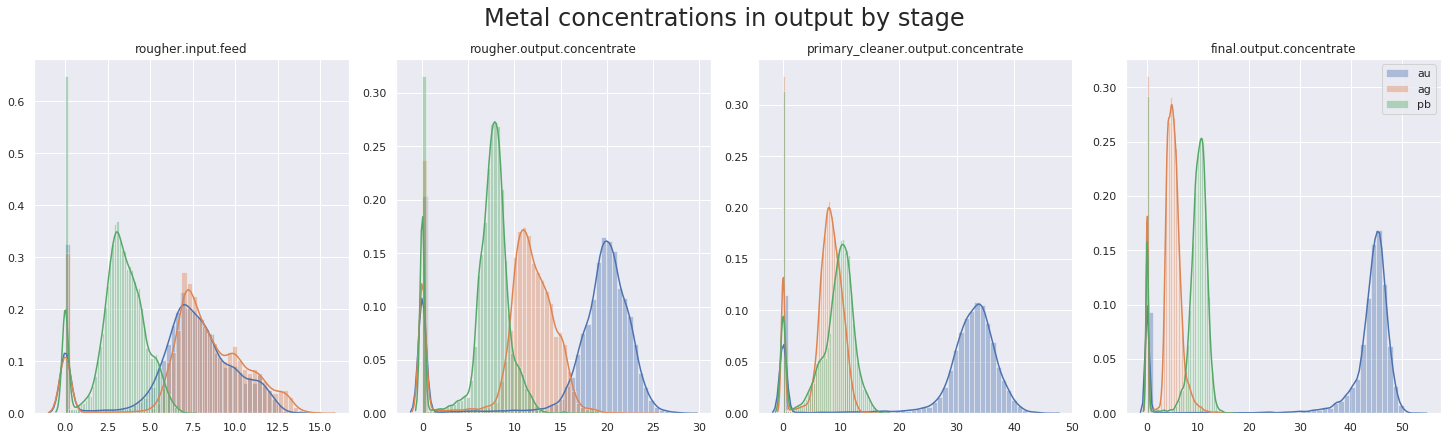

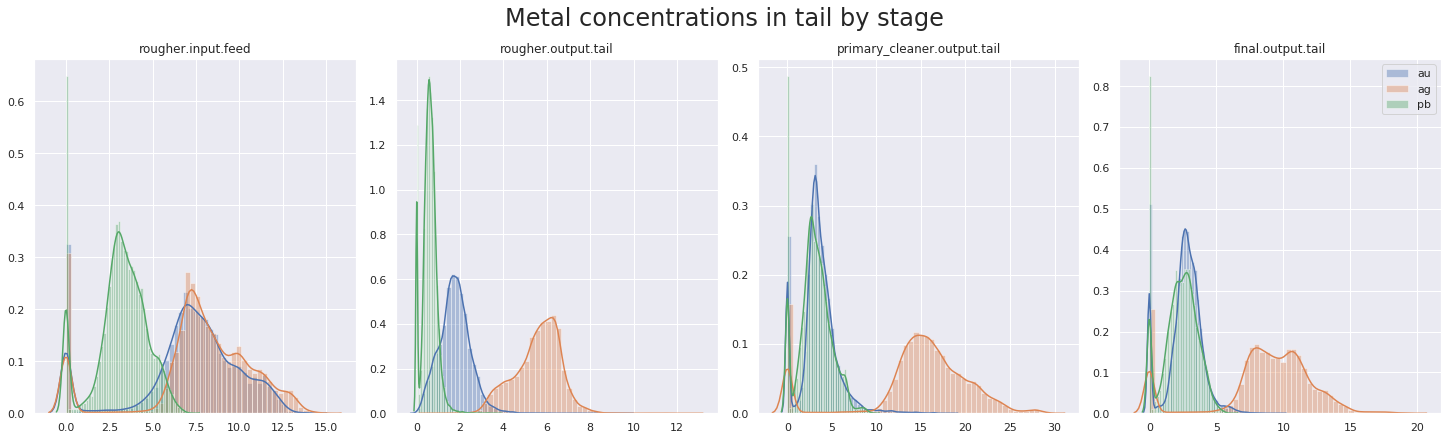

In [ ]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']

process_tail = ['rougher.input.feed',
                'rougher.output.tail',
                'primary_cleaner.output.tail',
                'final.output.tail']

metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Metal concentrations in output by stage', fontsize=24)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()

fig, axs = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Metal concentrations in tail by stage', fontsize=24)

for stage, ax in zip(process_tail, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=metal, ax=ax)   
plt.legend()

plt.show()

Из графиков видно что в процессе очистики концентрация золота возрастает, отметим достаточно большое количетсво нулевых значений

Так же отмети различную кноцентрацию металлов в хвостовых отвалах в после различных этапов

Дополнительно посторим графики для концентрации кадого металла на разны процессах на выходе и в хвосте

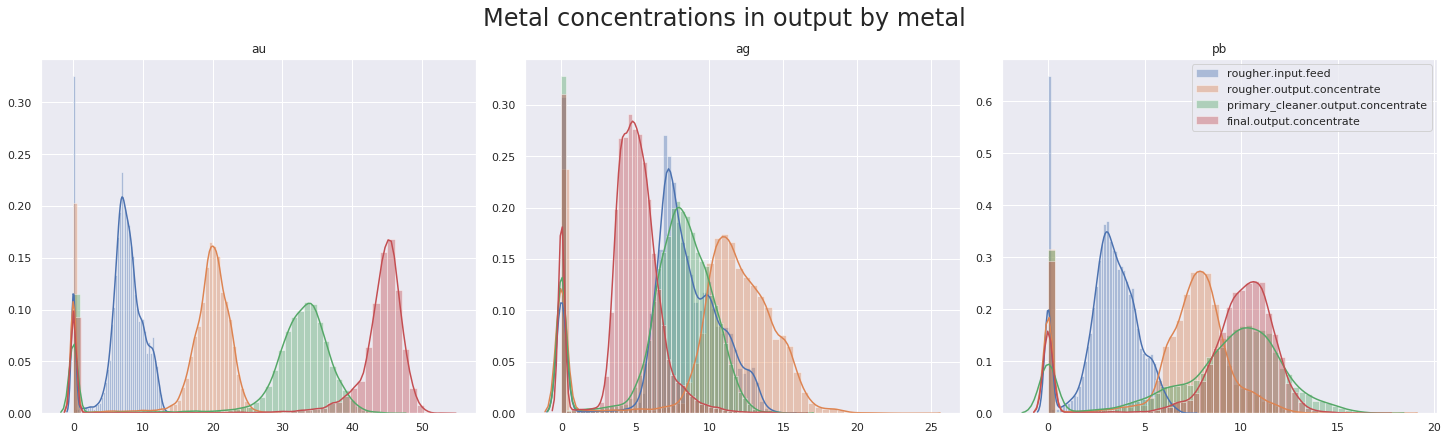

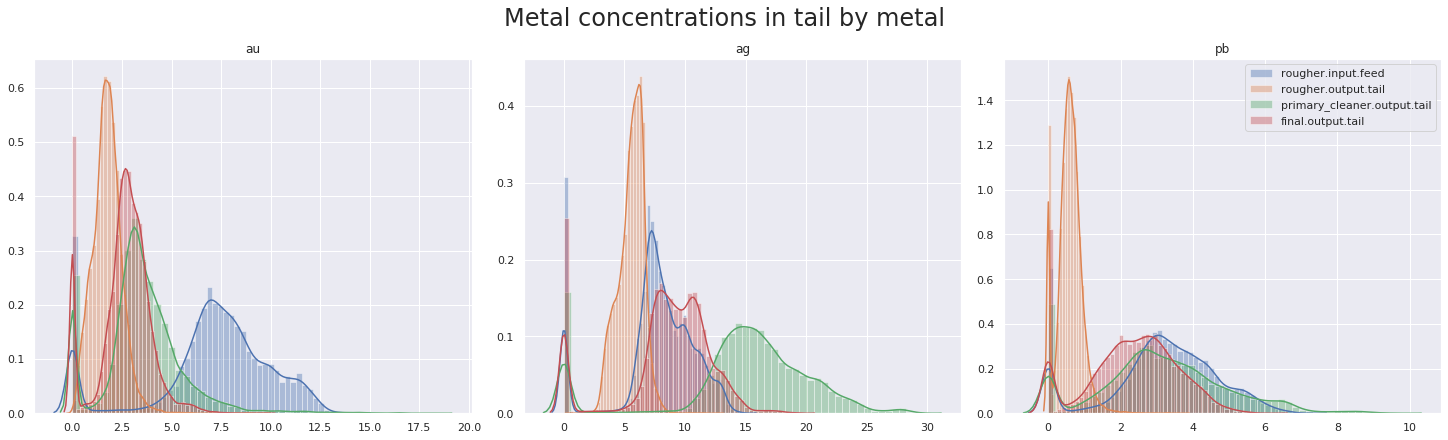

In [ ]:
fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Metal concentrations in output by metal', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Metal concentrations in tail by metal', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process_tail:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

plt.show()

Отметим, что концентрация золота по мере очистки значительно вырастает, так же вырастают концентрации серебра и свинца но не так значительно.

Самая большая концентрация золота в хвостах после флотации, при очиске концентрация золота в хвостах чуть меньше. Тоже самое характерно и для других металлов.

Проверим размер гранул сырья в train и в test

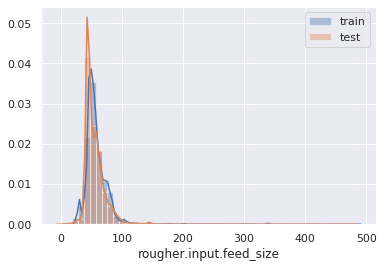

In [ ]:
sns.distplot(train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()

Распределения очень похожи

Исследуем суммарню концерацию в разных процессах в трейне и в тесте

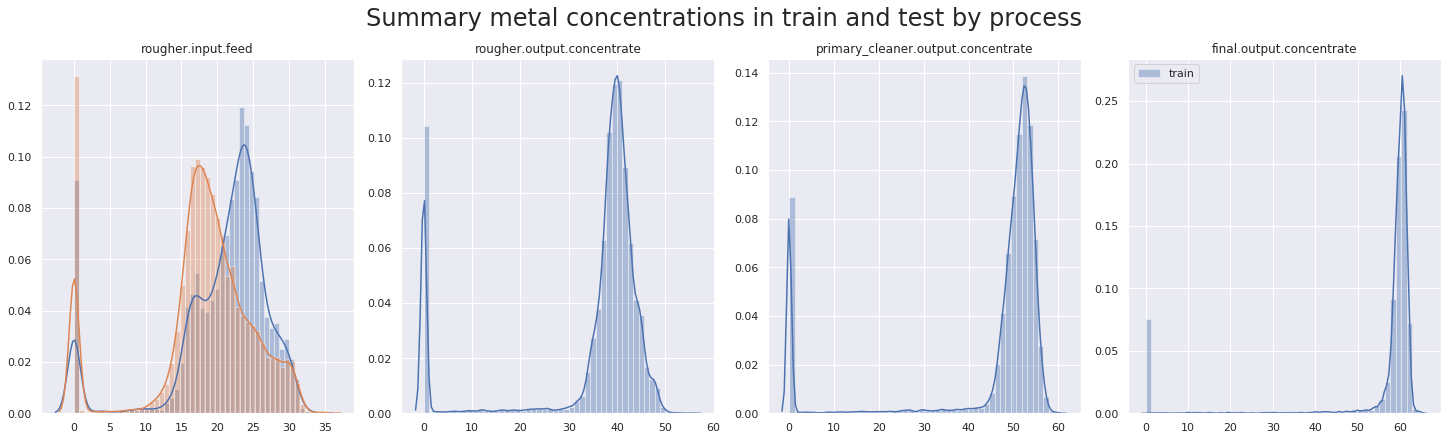

In [ ]:
fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Summary metal concentrations in train and test by process', fontsize=24)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    sum_train = train[stage+ '_ag'] + train[stage+ '_au'] + train[stage+ '_pb']
    try:
        sum_test = test[stage+ '_ag'] + test[stage+ '_au'] + test[stage+ '_pb']
        sns.distplot(sum_test.dropna(), label='test', ax=ax) 
    except KeyError:
        pass
    sns.distplot(sum_train.dropna(), label='train', ax=ax) 

plt.legend()
plt.show()

# 3. Модель

Реализуем расчет метрики sMAPE

- Учтем multioutput (рассчет метрики для двух и более столбцов)
- Учтем что формула теряет смысл если в знаменателе 0

In [ ]:
def sMAPE(y_true, y_pred, multioutput='uniform_average'):
    
    numerator = np.abs(y_true-y_pred)
    denominator =(np.abs(y_true)+np.abs(y_pred))/2
    
    output_errors = np.divide(numerator, denominator)
    
    nonzero_denominator = denominator == 0   
    output_errors[nonzero_denominator] = 0
    
    output_scores = np.average(output_errors, axis=0)
    
    if multioutput == 'raw_values':
        return output_scores
    elif multioutput == 'uniform_average':
        pass
    return np.average(output_scores)


neg_smape = make_scorer(sMAPE, greater_is_better=False)

Перейдем к машинному обучению, стратегия следующая:

1. Готовим пайплайн: Заполнение пропусков -> Скалер(для регрессии) -> Модель
2. Готовим параметры для поиска по сетке
3. Заполним пропуски в целевой переменной и удалим нули из нее. только для train
4. Делаем поиск по сетке, выбираем лучшую модель для флотации по метрике sMAPE
5. То же самое для очистки
6. Прогоняем пайплайн с лушими параметрами по всем данным, получаем предсказания для теста выходной и хвостовой концентраций
7. Расчитываем recovery, для каждой стадидии.
8. Подглядываем в full и смотрим конечное значение метрики

In [ ]:
pipe = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=state))
])

params = [
    {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [RandomForestRegressor(n_estimators=10, random_state=state)],
        'model__max_features': np.linspace(0.1, 1, 10)
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [LinearRegression()]
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [Ridge(random_state=state)],
        'model__alpha': np.logspace(-3, 1, 10)
    }, {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [Lasso(random_state=state)],
        'model__alpha': np.logspace(-3, 1, 10)
    }
]

In [ ]:
def fill_target_nan(y):
    y = y.interpolate()
    return y


def drop_target_zeros(X, y):
    y = y[(y != 0).all(1)]  
    X = X.loc[y.index, :]
    return X, y


print('Shapes before:')
print(X_train_rougher.shape, y_train_rougher.shape,
      X_train_cleaner.shape, y_train_cleaner.shape)

y_train_rougher = fill_target_nan(y_train_rougher)
y_train_cleaner = fill_target_nan(y_train_cleaner)

X_train_rougher, y_train_rougher = drop_target_zeros(X_train_rougher, y_train_rougher)
X_train_cleaner, y_train_cleaner = drop_target_zeros(X_train_cleaner, y_train_cleaner)        
                
print('Shapes after:')
print(X_train_rougher.shape, y_train_rougher.shape,
      X_train_cleaner.shape, y_train_cleaner.shape)

Shapes before:
(16860, 22) (16860, 2) (16860, 30) (16860, 2)
Shapes after:
(15313, 22) (15313, 2) (15038, 30) (15038, 2)


In [ ]:
cv =TimeSeriesSplit(n_splits=3)

grid_rougher = GridSearchCV(pipe, param_grid=params, cv=cv, scoring=neg_smape, n_jobs=-1)

In [ ]:
%%time
grid_rougher.fit(X_train_rougher, y_train_rougher)

CPU times: user 2min 24s, sys: 30.8 s, total: 2min 55s
Wall time: 2min 56s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(boo

In [ ]:
grid_rougher.best_params_, grid_rougher.best_score_

({'imp__strategy': 'mean',
  'model': Lasso(alpha=0.021544346900318832, copy_X=True, fit_intercept=True,
        max_iter=1000, normalize=False, positive=False, precompute=False,
        random_state=12345, selection='cyclic', tol=0.0001, warm_start=False),
  'model__alpha': 0.021544346900318832},
 -0.28370301506898915)

In [ ]:
grid_cleaner = GridSearchCV(pipe, param_grid=params, cv=cv, scoring=neg_smape, n_jobs=-1)

In [ ]:
%%time
grid_cleaner.fit(X_train_cleaner, y_train_cleaner)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.78075618692674, tolerance: 9.402729774037981
  positive)


CPU times: user 4min 4s, sys: 29.9 s, total: 4min 34s
Wall time: 4min 37s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(boo

In [ ]:
grid_cleaner.best_params_, grid_cleaner.best_score_

({'imp__strategy': 'mean',
  'model': Lasso(alpha=1.2915496650148828, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=False, positive=False, precompute=False, random_state=12345,
        selection='cyclic', tol=0.0001, warm_start=False),
  'model__alpha': 1.2915496650148828},
 -0.17534833465197444)

In [ ]:
input_au = test['rougher.input.feed_au'].fillna(0)

pipe_rougher = grid_rougher.best_estimator_

if type(pipe_rougher.steps[2][1]) is type(RandomForestRegressor()):    
    pipe_rougher.steps[2][1].n_estimators = 100 #с увеличением числа деревьев качество должно улучшаться
    
pipe_rougher.fit(X_train_rougher, y_train_rougher)

y_pred_rougher_tail, y_pred_rougher_conc = pipe_rougher.predict(X_test_rougher).T
rougher_recovery = recovery(y_pred_rougher_conc, input_au, y_pred_rougher_tail)

smape_rougher = sMAPE(full.loc[X_test_rougher.index, 'rougher.output.recovery'].interpolate(),
                      rougher_recovery.interpolate())
smape_rougher

0.10257891007215543

In [ ]:
type(pipe_rougher.steps[2][1])

sklearn.linear_model.coordinate_descent.Lasso

In [ ]:
pipe_cleaner = grid_cleaner.best_estimator_

if type(pipe_cleaner.steps[2][1]) is type(RandomForestRegressor()):    
    pipe_cleaner.steps[2][1].n_estimators = 100 #с увеличением числа деревьев качество должно улучшаться
    
pipe_cleaner.fit(X_train_cleaner, y_train_cleaner)

y_pred_cleaner_tail, y_pred_cleaner_conc = pipe_cleaner.predict(X_test_cleaner).T
cleaner_recovery = recovery(y_pred_cleaner_conc, input_au, y_pred_cleaner_tail)

smape_cleaner = sMAPE(full.loc[X_test_rougher.index, 'final.output.recovery'].fillna(0),
                      cleaner_recovery.fillna(0))
smape_cleaner

0.1348133876901321

In [ ]:
final_smape = 0.25*smape_rougher + 0.75*smape_cleaner
final_smape

0.12675476828563795

Метрика - достаточно низкая.  
Вот только не понятно насколько  
По хорошему, здесь надо понять: наша модель предсказывает лучше, чем просто по среднему. Получится, например, 16%. Тогда ОК. Наша модель даёт в среднем -4% выгоды  

#### Проверим модель на адекватность (сравним с константной моделью)

In [ ]:
# Проверка адекватности в сравнении с константной моделью (выдающей всегда медианное значение)
smape_rougher_constant = sMAPE(full.loc[X_test_rougher.index, 'rougher.output.recovery'].interpolate(),
                      full.loc[X_test_rougher.index, 'rougher.output.recovery'].interpolate().median())

smape_cleaner_constant = sMAPE(full.loc[X_test_rougher.index, 'final.output.recovery'].fillna(0),
                      full.loc[X_test_rougher.index, 'final.output.recovery'].fillna(0).median())
final_smape_constant = 0.25*smape_rougher_constant + 0.75*smape_cleaner_constant
final_smape_constant

0.20626507952868992

In [ ]:
# сравним модели
pd.DataFrame({'Final_smape_constant_model' : [final_smape_constant, final_smape_constant/final_smape*100], 
              'Final_smape': [final_smape, final_smape/final_smape*100]}, 
             index=['Value','Percentage of final_smape'])

,Final_smape_constant_model,Final_smape
Value,0.206265,0.126755
Percentage of final_smape,162.727669,100.000000


Констатная модель показывает качество по заданной метрике 0.206, наша модель дает качество 0.127. Т.е. можем сделать вывод, что наша модель работае примерно на 7.5% в абсолютном значении и на 62.7% в относительном значнии лучше, чем константная

# Общий вывод:
- В ходе работы была исследована эффективность обогащения золотосодержащей руды, исследованы различные параметры на разных этапах технологического процесса. Было выяснено, что концентрация золота по мере очистки значительно вырастает.
- Самая большая концентрация золота в хвостах после флотации
- Построена модель c помощью поиска по сетке, лучшей оказалась линейная модель с лассо регуляризацией

Данная модель ведёт себя на 7.5 процентов лучше, чем константная модель с медианным значением. Что говорит о том, что модель может считаться адекватной)